# Giriş
Bu projenin amacı: 7 farklı göz hastalıkları hücresinin mikroskobik fotoğraflarının makine öğrenimi yöntemlerini kullanarak işlenip, verilen görsellerin hangi göz hastalığı grubuna ait olduğunu  tahmin eden, yüksek başarımlı bir makine öğrenim modeli oluşturulması hedeflenmektedir.


# İçindekiler
* [Veri Setini Anlamak](#veri-setini-anlamak)
* [Veriyi Okumak](#veriyi-okumak)
    * [Dosya İşlemleri](#dosya-islemleri)
* [Keşifsel Veri Analizi](#veriyi-okumak)
    * [İlişkili Verilerin Bulunması (Corelation)](#veriyi-okumak)
    * [Aykırı Değer (Outlier) Tespiti ve Yönetimi](#veriyi-okumak)
    * [Normalizasyon İşlemleri](#veri-okumak)
* [Model Seçimi](#veriyi-okumak)
    * [En İyi Parametrelerin Bulunması](#veriyi-okumak)
    * --
    * --
    * --
* [Sonuç Değerlendirmesi](#veriyi-okumak)

## Veri Setini Anlamak <a class="anchor" id="veri-setini-anlamak"></a>
Çalışacağımız veri seti "Ocular Disease Recognition" Normal, Cataract, Diabetes, Age related Macular degeneration, Pathological Myopia ve Glaucoma retina görsellerini barındırır. 
. Sırasıyla retinal türlerin açıklaması aşağıdaki gibidir.
- Normal (N) : Herhangi bir anomalite bulundurmayan sağlıklı göz dokusu.
- Diabetes (D) : Glukoz seviyesinin aşırı derecede yükselmesiyle (hiperglisemi) sonuçlanan metabolik bir bozukluk sebebiyle körlük yapabilen hastalık.[1]
- Glaucoma (G) : Optik sinirde (veya retina da ) hasarla sonuçlanan ve görme kaybına neden olan bir grup göz hastalığıdır.[2]
- Cataract (C) :  Doğal göz merceğinin matlaşması ve yüzeyinde oluşan çeşitli lekelenmelerle birlikte saydamlığını yitirmesiyle oluşan bir göz hastalığıdır.[3]
- Age related Macular Degeneration (A) : Halk arasında "sarı nokta hastalığı" diye bilinen "yaşa bağlı makula dejenerasyonu" zamanla ilerleyerek makulayı tamamen hasara uğratabilen dejeneratif bir hastalıktır.[4]
- Hypertension (H) : Yüksek kan basıncının retinada yaptığı hasara hipertansif retinopati denir.[5]
- Pathological Myopia (M) : Patolojik miyopi, aşırı yüksek miyopik kusurun neden olduğu ve ciddi göz hastalıklarına yol açabilen bir hastalıktır.
- Other diseases/abnormalities (O) : Yukarıda olmayan diğer anormallikler ve rahatszılıklar.

## Veriyi Okumak <a class="anchor" id="veriyi-okumak"></a>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings 
import os
from PIL import Image

### Dosya İşlemleri <a class="anchor" id="dosya-islemleri"></a>

In [2]:
df = pd.read_csv("full_df.csv")
df.head

<bound method NDFrame.head of         ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
0        0           69      Female     0_left.jpg     0_right.jpg   
1        1           57        Male     1_left.jpg     1_right.jpg   
2        2           42        Male     2_left.jpg     2_right.jpg   
3        4           53        Male     4_left.jpg     4_right.jpg   
4        5           50      Female     5_left.jpg     5_right.jpg   
...    ...          ...         ...            ...             ...   
6387  4686           63        Male  4686_left.jpg  4686_right.jpg   
6388  4688           42        Male  4688_left.jpg  4688_right.jpg   
6389  4689           54        Male  4689_left.jpg  4689_right.jpg   
6390  4690           57        Male  4690_left.jpg  4690_right.jpg   
6391  4784           58        Male  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
0                                              cataract   
1          

In [3]:
df.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

Veri setimizde null değer olmadığı için missing values methodolojilerini uygulamıza gerek kalmadı.

AttributeError: 'AxesSubplot' object has no attribute 'set_ylabels'

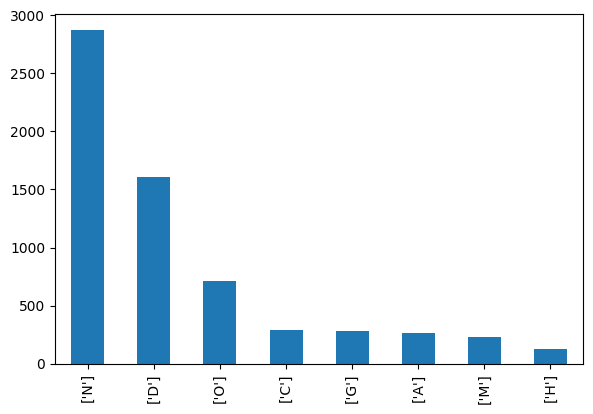

In [5]:
age_groups = pd.cut(df['Patient Age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100])
age_counts = age_groups.value_counts(sort=False)

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
df['labels'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabels('Toplam')
ax1.set_title('Hastalık Türü')

ax2 = fig.add_subplot(222)
df['Patient Sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Toplam')
ax2.set_title('Hastanın Cinsiyeti')

ax3 = fig.add_subplot(223)
df.groupby(age_groups)['labels'].value_counts().unstack().plot(kind='bar', ax=ax3)
ax3.set_xlabel('Yaş Grupları')
ax3.set_ylabel('Toplam')
ax3.set_title('Yaş vs Hastalık Türü')

plt.show()

##TODO: 'AxesSubplot' object has no attribute 'set_ylabels' çozulecek


Üstteki çizimlerden anlaşılacağı üzere hangi hastalığın ne kadar görüldüğü, yaşa bağlı hastalıkların görülme sıklığını ve cinsiyete göre dağılımlarını rahatça görebiliriz. Aynı zamanda sınıflandırma yapmadan önce verilerin dengeli olması gerekli ki, modelimiz farklı hastalık türünü farklı ağırlıklar vermesin. Örneğin bizim verimizde N (Normal) şeklindme tanımlanan grup veri setinde en fazla olduğu için modelimiz N grubuna daha yüksek ağırlık verecek. Bunu önlemek için scikit-learn kütüphanesinin resample modülüyle örnek sayılarını dengeli hale getirebiliriz.

In [6]:
from sklearn.utils import resample
print(df['labels'].value_counts())

df_0 = df[df['labels'] == 0]
df_1 = df[df['labels'] == 1]
df_2 = df[df['labels'] == 2]
df_3 = df[df['labels'] == 3]
df_4 = df[df['labels'] == 4]
df_5 = df[df['labels'] == 5]
df_6 = df[df['labels'] == 6]
df_7 = df[df['labels'] == 7]


n_samples=10
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)
df_7_balanced = resample(df_7, replace=True, n_samples=n_samples, random_state=42)


df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced, df_7_balanced])


print(df_balanced['labels'].value_counts())
df_balanced

##TODO: Verileri resample edilecek. Başka metodlarda kullanılabilir.


['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: labels, dtype: int64


ValueError: high <= 0

Kategorik verileri target içerisinde tüm hastalık türleri için one hot encoding işlemi veri seti içinde tanımlı. Veri setine göre Hastalık türlerinin sayısı dengesiz olarak dağılmış.
- Görsel verilerin aynı şekilde formatlandırılması (boyut, renk olabilir olmayadabililir vb.)
- TODO: Hue plot çizimi (standaritzasyon işlemin önce ve sonra )
- TODO: Verilerin bias dağılımları düzenlenecek şekilde resample edilecek.
- TODO: Veri standartizasyon işlemleri.
- TODO: Outlier ve Skewness Kontrolü.


# Kaynakça
 TODO: Kaynakça kısmı örnek bitirme tezlerine bakılarak tekrar düzenlenecek.
- [1]-https://tr.wikipedia.org/wiki/Diyabet
- [2]-https://en.wikipedia.org/wiki/Glaucoma
- [3]-https://venividigoz.com/katarakt-nedir-belirtileri-nelerdir
- [4]-https://www.istanbulretina.com/yasa-bagli-makula-dejenerasyonu-riski.php#:~:text=Halk%20aras%C4%B1nda%20%22sar%C4%B1%20nokta%20hastal%C4%B1%C4%9F%C4%B1,alan%C4%B1n%C4%B1n%20ortas%C4%B1nda%20karama%20ortaya%20%C3%A7%C4%B1kar.
- [5]-https://www.istanbulretina.com/hipertansif-retinopati-hastalik-belirtisi-tedavisi.php



Yazım Kuralları:
- Ana başlıklar tek diez (#)
- Alt başlıklar iki diez(##)
- Alt başlığın alt başlıklarıan üç diez (###)
- Table of content için a class anchor id ler ise küçük ve boşluklar tireli olarak adlandırılacakarv Veri Seti başlığı idsi id=veri-seti gibi.